Sveučilište u Zagrebu<br>
Fakultet elektrotehnike i računarstva

## Uvod u znanost o podacima


# Priprema i vizualizacija podataka

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt

## Prikaz podataka o datotekama i člancima

In [3]:
import os
import re

files = os.listdir('reuters21578')

columns = ['FILENAME', 'NEWID', 'OLDID', 'LEWISSPLIT', 'CGISPLIT', 'TOPICS_ENUM', 'TEXT TYPE', 'DATE', 'TITLE', 'AUTHOR', 'DATELINE', 'TOPICS', 'PLACES', 'PEOPLE', 'ORGS', 'EXCHANGES', 'COMPANIES',  'BODY']
rows = []

for filename in os.listdir('reuters21578'):
    if filename.endswith(".sgm"):
        file_content = open(os.path.join("reuters21578", filename), mode = 'r', encoding='ascii', errors='ignore').read()
        articles = file_content.split("</REUTERS>")
        articles[0] = articles[0][articles[0].find("\n")::] ## izbacimo prvi red, onaj <!DOCSTYLE ...
        #print(articles[0])
        
        for article in articles:
            if "<REUTERS" in article:
                red = {}
                red['FILENAME'] = filename
                red['NEWID'] = re.findall('NEWID="([^"]*)"', article)[0]
                red['OLDID'] = re.findall('OLDID="([^"]*)"', article)[0]
                red['TOPICS_ENUM'] = re.findall('TOPICS="([^"]*)"', article)[0]
                red['TEXT TYPE'] = "".join(re.findall('TEXT TYPE="([^"]*)"', article))
                red['LEWISSPLIT'] = re.findall('LEWISSPLIT="([^"]*)"', article)[0]
                red['CGISPLIT'] = re.findall('CGISPLIT="([^"]*)"', article)[0]
                for znacajka in columns[7:]:
                    if znacajka == "DATE":
                        regex = '<' + znacajka + '>' + '([^&#$]*)' + '</' + znacajka + '>'
                    else:
                        regex = '<' + znacajka + '>' + '([\s\S]*)' + '</' + znacajka + '>'
                    match = re.findall(regex, article)
                    if(len(match)==0):
                        continue
                    elif match[0] == '':
                        continue
                    else:
                        match = match[0]
                        if '<D>' in match:
                            match = match.replace('<D>', '')
                            match = match.split('</D>')
                            match = match[:-1]
                        red[znacajka] = match
                #print(red[0:-1])
                rows.append(red.copy())

dataframe = pd.DataFrame(rows, columns=['NEWID', 'TOPICS', 'PLACES', 'PEOPLE', 'ORGS', 'EXCHANGES', 'TITLE', 'AUTHOR', 'DATELINE', 'OLDID', 'TOPICS_ENUM', 'FILENAME', 'DATE', 'COMPANIES', 'BODY', 'TEXT TYPE', 'LEWISSPLIT', 'CGISPLIT'])
dataframe = dataframe.astype('string')
dataframe = dataframe.astype({'NEWID' : 'int64', 'OLDID' : 'int64'})
#dataframe = dataframe.set_index("NEWID")

### Prikaz prvih 10 redova

In [4]:
dataframe.head(n=10)

,NEWID,TOPICS,PLACES,PEOPLE,ORGS,EXCHANGES,TITLE,AUTHOR,DATELINE,OLDID,TOPICS_ENUM,FILENAME,DATE,COMPANIES,BODY,TEXT TYPE,LEWISSPLIT,CGISPLIT
0,1,['cocoa'],"['el-salvador', 'usa', 'uruguay']",<NA>,<NA>,<NA>,BAHIA COCOA REVIEW,<NA>,"SALVADOR, Feb 26 -",5544,YES,reut2-000.sgm,26-FEB-1987 15:01:01.79,<NA>,Showers continued throughout the week in the B...,,TRAIN,TRAINING-SET
1,2,<NA>,['usa'],<NA>,<NA>,<NA>,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,<NA>,"CLEVELAND, Feb 26 -",5545,NO,reut2-000.sgm,26-FEB-1987 15:02:20.00,<NA>,Standard Oil Co and BP North America Inc said ...,,TRAIN,TRAINING-SET
2,3,<NA>,['usa'],<NA>,<NA>,<NA>,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,<NA>,"HOUSTON, Feb 26 -",5546,NO,reut2-000.sgm,26-FEB-1987 15:03:27.51,<NA>,Texas Commerce Bancshares Inc's Texas Commerce...,,TRAIN,TRAINING-SET
3,4,<NA>,"['usa', 'brazil']",<NA>,<NA>,<NA>,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,"by Janie Gabbett, Reuters","LOS ANGELES, Feb 26 -",5547,NO,reut2-000.sgm,26-FEB-1987 15:07:13.72,<NA>,BankAmerica Corp is not under pressure to act ...,,TRAIN,TRAINING-SET
4,5,"['grain', 'wheat', 'corn', 'barley', 'oat', 's...",['usa'],<NA>,<NA>,<NA>,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,<NA>,"WASHINGTON, Feb 26 -",5548,YES,reut2-000.sgm,26-FEB-1987 15:10:44.60,<NA>,The U.S. Agriculture Department reported the f...,,TRAIN,TRAINING-SET
5,6,"['veg-oil', 'linseed', 'lin-oil', 'soy-oil', '...",['argentina'],<NA>,<NA>,<NA>,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,<NA>,"BUENOS AIRES, Feb 26 -",5549,YES,reut2-000.sgm,26-FEB-1987 15:14:36.41,<NA>,Argentine grain board figures show crop regist...,,TRAIN,TRAINING-SET
6,7,<NA>,['usa'],<NA>,<NA>,<NA>,RED LION INNS FILES PLANS OFFERING,<NA>,"PORTLAND, Ore., Feb 26 -",5550,NO,reut2-000.sgm,26-FEB-1987 15:14:42.83,<NA>,Red Lion Inns Limited Partnership said it file...,,TRAIN,TRAINING-SET
7,8,<NA>,['usa'],<NA>,<NA>,<NA>,USX &lt;X> DEBT DOWGRADED BY MOODY'S,<NA>,"NEW YORK, Feb 26 -",5551,YES,reut2-000.sgm,26-FEB-1987 15:15:40.12,<NA>,Moody's Investors Service Inc said it lowered ...,,TRAIN,TRAINING-SET
8,9,['earn'],['usa'],<NA>,<NA>,<NA>,CHAMPION PRODUCTS &lt;CH> APPROVES STOCK SPLIT,<NA>,"ROCHESTER, N.Y., Feb 26 -",5552,YES,reut2-000.sgm,26-FEB-1987 15:17:11.20,<NA>,Champion Products Inc said its board of direct...,,TRAIN,TRAINING-SET
9,10,['acq'],['usa'],<NA>,<NA>,<NA>,COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...,<NA>,"COMMACK, N.Y., Feb 26 -",5553,YES,reut2-000.sgm,26-FEB-1987 15:18:06.67,<NA>,Computer Terminal Systems Inc said it has comp...,,TRAIN,TRAINING-SET


### Pohrana Dataframe-a

In [5]:
filename = "clanci.csv"
dataframe.to_csv(filename)

In [6]:
clanci = pd.read_csv(filename, index_col = 0)
clanci.head(n=10)

,NEWID,TOPICS,PLACES,PEOPLE,ORGS,EXCHANGES,TITLE,AUTHOR,DATELINE,OLDID,TOPICS_ENUM,FILENAME,DATE,COMPANIES,BODY,TEXT TYPE,LEWISSPLIT,CGISPLIT
0,1,['cocoa'],"['el-salvador', 'usa', 'uruguay']",NaN,NaN,NaN,BAHIA COCOA REVIEW,NaN,"SALVADOR, Feb 26 -",5544,YES,reut2-000.sgm,26-FEB-1987 15:01:01.79,NaN,Showers continued throughout the week in\nthe ...,NaN,TRAIN,TRAINING-SET
1,2,NaN,['usa'],NaN,NaN,NaN,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,NaN,"CLEVELAND, Feb 26 -",5545,NO,reut2-000.sgm,26-FEB-1987 15:02:20.00,NaN,Standard Oil Co and BP North America\nInc said...,NaN,TRAIN,TRAINING-SET
2,3,NaN,['usa'],NaN,NaN,NaN,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,NaN,"HOUSTON, Feb 26 -",5546,NO,reut2-000.sgm,26-FEB-1987 15:03:27.51,NaN,Texas Commerce Bancshares Inc's Texas\nCommerc...,NaN,TRAIN,TRAINING-SET
3,4,NaN,"['usa', 'brazil']",NaN,NaN,NaN,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,"by Janie Gabbett, Reuters","LOS ANGELES, Feb 26 -",5547,NO,reut2-000.sgm,26-FEB-1987 15:07:13.72,NaN,BankAmerica Corp is not under\npressure to act...,NaN,TRAIN,TRAINING-SET
4,5,"['grain', 'wheat', 'corn', 'barley', 'oat', 's...",['usa'],NaN,NaN,NaN,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,NaN,"WASHINGTON, Feb 26 -",5548,YES,reut2-000.sgm,26-FEB-1987 15:10:44.60,NaN,The U.S. Agriculture Department\nreported the ...,NaN,TRAIN,TRAINING-SET
5,6,"['veg-oil', 'linseed', 'lin-oil', 'soy-oil', '...",['argentina'],NaN,NaN,NaN,ARGENTINE 1986/87 GRAIN/OILSEED REGISTRATIONS,NaN,"BUENOS AIRES, Feb 26 -",5549,YES,reut2-000.sgm,26-FEB-1987 15:14:36.41,NaN,Argentine grain board figures show\ncrop regis...,NaN,TRAIN,TRAINING-SET
6,7,NaN,['usa'],NaN,NaN,NaN,RED LION INNS FILES PLANS OFFERING,NaN,"PORTLAND, Ore., Feb 26 -",5550,NO,reut2-000.sgm,26-FEB-1987 15:14:42.83,NaN,Red Lion Inns Limited Partnership\nsaid it fil...,NaN,TRAIN,TRAINING-SET
7,8,NaN,['usa'],NaN,NaN,NaN,USX &lt;X> DEBT DOWGRADED BY MOODY'S,NaN,"NEW YORK, Feb 26 -",5551,YES,reut2-000.sgm,26-FEB-1987 15:15:40.12,NaN,Moody's Investors Service Inc said it\nlowered...,NaN,TRAIN,TRAINING-SET
8,9,['earn'],['usa'],NaN,NaN,NaN,CHAMPION PRODUCTS &lt;CH> APPROVES STOCK SPLIT,NaN,"ROCHESTER, N.Y., Feb 26 -",5552,YES,reut2-000.sgm,26-FEB-1987 15:17:11.20,NaN,Champion Products Inc said its\nboard of direc...,NaN,TRAIN,TRAINING-SET
9,10,['acq'],['usa'],NaN,NaN,NaN,COMPUTER TERMINAL SYSTEMS &lt;CPML> COMPLETES ...,NaN,"COMMACK, N.Y., Feb 26 -",5553,YES,reut2-000.sgm,26-FEB-1987 15:18:06.67,NaN,Computer Terminal Systems Inc said\nit has com...,NaN,TRAIN,TRAINING-SET


### Pregled podataka

In [7]:
broj_primjeraka, broj_znacajki = clanci.shape
print("broj primjeraka (članaka), N = {}".format(broj_primjeraka))
print("broj značajki, n = {}".format(broj_znacajki))

broj primjeraka (članaka), N = 21578
broj značajki, n = 18


In [8]:
print("Koliko članaka ima u svakoj datoteci:")
print(clanci.groupby('FILENAME').size())

Koliko članaka ima u svakoj datoteci:
FILENAME
reut2-000.sgm    1000
reut2-001.sgm    1000
reut2-002.sgm    1000
reut2-003.sgm    1000
reut2-004.sgm    1000
reut2-005.sgm    1000
reut2-006.sgm    1000
reut2-007.sgm    1000
reut2-008.sgm    1000
reut2-009.sgm    1000
reut2-010.sgm    1000
reut2-011.sgm    1000
reut2-012.sgm    1000
reut2-013.sgm    1000
reut2-014.sgm    1000
reut2-015.sgm    1000
reut2-016.sgm    1000
reut2-017.sgm    1000
reut2-018.sgm    1000
reut2-019.sgm    1000
reut2-020.sgm    1000
reut2-021.sgm     578
dtype: int64


Značajke:
- **newid** - id koji članak ima u Reuters-21578 klasifikaciji
- **topics** - lista kategorija tema kojima članak pripada
- **places** - lista kategorija mjesta kojima članak pripada
- **people** - lista kategorija ljudi kojima članak pripada
- **orgs** - lista kategorija orgs kojima članak pripada
- **exchange** - lista kategorija razmjena kojima članak pripada
- **title** - naslov članka
- **author** - autor teksta
- **dateline** - od kod je članak potekao, i dan u godini
- **oldid** - id koji je članak imao u Reuters-22173 klasifikaciji
- **topics enum** - moguće vrijednosti su [YES, NO, BYPASS], je li dokument imao topics kategoriju u originalnom datasetu
- **filename** - ime datoteke u kojoj se nalazi članak
- **date** - datum i vrijeme dokumenta
- **companies** - ?
- **body** - tijelo teksta
- **text type** - moguće vrijednosti su [NORM, BRIEF, UNPROC], norm znači da tekst ima normalnu strukturu, brief znači da je tekst kratak, unproc znači da tekst ima neobičnu strukturu
- **lewissplit** - moguće vrijednosti su [TRAINING, TEST, NOT_USED] ovisno o tome za što se članak koristio u eksperimentima u izvješćima: LEWIS91d (poglavlja 9 i 10), LEWIS92b, LEWIS92e i LEWIS94b
- **cgisplit** - moguće vrijednosti su [TRAINING-SET, PUBLISHED-TESTSET] ovisno o tome za što se članak koristi u eksperimentima  u izvješćima HAYES89 i HAYES90b

In [9]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21578 entries, 0 to 21577
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   NEWID        21578 non-null  int64 
 1   TOPICS       11367 non-null  string
 2   PLACES       18798 non-null  string
 3   PEOPLE       1156 non-null   string
 4   ORGS         881 non-null    string
 5   EXCHANGES    482 non-null    string
 6   TITLE        20841 non-null  string
 7   AUTHOR       875 non-null    string
 8   DATELINE     19043 non-null  string
 9   OLDID        21578 non-null  int64 
 10  TOPICS_ENUM  21578 non-null  string
 11  FILENAME     21578 non-null  string
 12  DATE         21250 non-null  string
 13  COMPANIES    0 non-null      string
 14  BODY         19043 non-null  string
 15  TEXT TYPE    21578 non-null  string
 16  LEWISSPLIT   21578 non-null  string
 17  CGISPLIT     21578 non-null  string
dtypes: int64(2), string(16)
memory usage: 3.0 MB


#### Monotoni atributi

In [10]:
dataframe.nunique() # gledamo ako ima monotonih značajki

NEWID          21578
TOPICS           655
PLACES          1096
PEOPLE           217
ORGS              67
EXCHANGES         57
TITLE          20029
AUTHOR           351
DATELINE        8822
OLDID          21578
TOPICS_ENUM        3
FILENAME          22
DATE           21250
COMPANIES          0
BODY           18781
TEXT TYPE          3
LEWISSPLIT         3
CGISPLIT           2
dtype: int64

Zaključujemo da su NEWID i OLDID monotone značajke. 

In [11]:
original = dataframe.copy() #čuvamo original podataka, just in case
podaci = original.copy()

podaci = podaci.drop('OLDID', axis=1, inplace=False)
podaci.drop('NEWID', axis=1, inplace=True)

In [12]:
podaci.isna().sum() # broji nul vrijednosti za značajke

TOPICS         10211
PLACES          2780
PEOPLE         20422
ORGS           20697
EXCHANGES      21096
TITLE            737
AUTHOR         20703
DATELINE        2535
TOPICS_ENUM        0
FILENAME           0
DATE             328
COMPANIES      21578
BODY            2535
TEXT TYPE          0
LEWISSPLIT         0
CGISPLIT           0
dtype: int64

Vidimo da osim značajki za klasifikacijske oznake (topics, places, people, orgs, exchanges), značajke AUTHOR i COMPANIES imaju puno nul vrijednosti. Izbacujemo te značajke iz skupa podataka.

In [13]:
podaci.drop(['AUTHOR', 'COMPANIES'], axis=1, inplace=True)

Izbacujemo zapise koji nemaju body jer nam oni zapravo ništa ne govore.

In [14]:
podaci = podaci.loc[podaci.BODY.notnull(), :] # zadržavamo samo one zapise kojima body nije null

#### Label Encoder
Mijenjamo format značajki koje imaju malo unique vrijednosti (poprimaju vrijednosti iz nekog diskretnog skupa) - topics_enum, text type, lewisspit, cgisplit.

In [15]:
le = LabelEncoder()
le.fit(podaci.loc[:, 'TOPICS_ENUM'])
podaci.loc[:, 'TOPICS_ENUM'] = le.transform(podaci.loc[:, 'TOPICS_ENUM'])
le.fit(podaci.loc[:, 'TEXT TYPE'])
podaci.loc[:, 'TEXT TYPE'] = le.transform(podaci.loc[:, 'TEXT TYPE'])
le.fit(podaci.loc[:, 'LEWISSPLIT'])
podaci.loc[:, 'LEWISSPLIT'] = le.transform(podaci.loc[:, 'LEWISSPLIT'])
le.fit(podaci.loc[:, 'CGISPLIT'])
podaci.loc[:, 'CGISPLIT'] = le.transform(podaci.loc[:, 'CGISPLIT'])
podaci

,TOPICS,PLACES,PEOPLE,ORGS,EXCHANGES,TITLE,DATELINE,TOPICS_ENUM,FILENAME,DATE,BODY,TEXT TYPE,LEWISSPLIT,CGISPLIT
0,['cocoa'],"['el-salvador', 'usa', 'uruguay']",<NA>,<NA>,<NA>,BAHIA COCOA REVIEW,"SALVADOR, Feb 26 -",2,reut2-000.sgm,26-FEB-1987 15:01:01.79,Showers continued throughout the week in the B...,0,2,1
1,<NA>,['usa'],<NA>,<NA>,<NA>,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,"CLEVELAND, Feb 26 -",1,reut2-000.sgm,26-FEB-1987 15:02:20.00,Standard Oil Co and BP North America Inc said ...,0,2,1
2,<NA>,['usa'],<NA>,<NA>,<NA>,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,"HOUSTON, Feb 26 -",1,reut2-000.sgm,26-FEB-1987 15:03:27.51,Texas Commerce Bancshares Inc's Texas Commerce...,0,2,1
3,<NA>,"['usa', 'brazil']",<NA>,<NA>,<NA>,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,"LOS ANGELES, Feb 26 -",1,reut2-000.sgm,26-FEB-1987 15:07:13.72,BankAmerica Corp is not under pressure to act ...,0,2,1
4,"['grain', 'wheat', 'corn', 'barley', 'oat', 's...",['usa'],<NA>,<NA>,<NA>,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,"WASHINGTON, Feb 26 -",2,reut2-000.sgm,26-FEB-1987 15:10:44.60,The U.S. Agriculture Department reported the f...,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21573,['ship'],"['hong-kong', 'japan', 'india', 'pakistan', 'i...",<NA>,<NA>,<NA>,JAPAN/INDIA CONFERENCE CUTS GULF WAR RISK CHARGES,"HONG KONG, Oct 19 -",2,reut2-021.sgm,19-OCT-1987 00:34:08.94,The Japan/India-Pakistan-Gulf/Japan shipping c...,0,1,1
21574,['ipi'],['ussr'],<NA>,<NA>,<NA>,SOVIET INDUSTRIAL GROWTH/TRADE SLOWER IN 1987,"MOSCOW, Oct 19 -",2,reut2-021.sgm,19-OCT-1987 00:18:22.79,The Soviet Union's industrial output is growin...,0,1,1
21575,['gold'],['south-africa'],<NA>,<NA>,<NA>,SIX KILLED IN SOUTH AFRICAN GOLD MINE ACCIDENT,"JOHANNESBURG, Oct 19 -",2,reut2-021.sgm,19-OCT-1987 00:05:11.26,Six black miners have been killed and two inju...,0,1,1
21576,<NA>,['switzerland'],<NA>,<NA>,<NA>,PROJECTIONS SHOW SWISS VOTERS WANT TRIED PARTIES,"BERNE, Oct 19 -",1,reut2-021.sgm,19-OCT-1987 00:03:21.69,The prospect of a dominant alliance of sociali...,0,1,1


In [16]:
podaci.describe(include='all')

,TOPICS,PLACES,PEOPLE,ORGS,EXCHANGES,TITLE,DATELINE,TOPICS_ENUM,FILENAME,DATE,BODY,TEXT TYPE,LEWISSPLIT,CGISPLIT
count,10377,18398,1012,854,402,19043,19043,19043.000000,19043,18745,19043,19043.0,19043.000000,19043.000000
unique,646,1095,214,66,57,18253,8822,NaN,22,18745,18781,NaN,NaN,NaN
top,['earn'],['usa'],['reagan'],['ec'],['nyse'],PROPOSED OFFERINGS RECENTLY FILED WITH THE SEC,"WASHINGTON, April 9 -",NaN,reut2-016.sgm,26-FEB-1987 15:01:01.79,The Bundesbank left credit policies\nunchanged...,NaN,NaN,NaN
freq,3735,10685,106,296,69,25,111,NaN,947,1,4,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.626372,NaN,NaN,NaN,0.0,1.637767,0.962191
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.527006,NaN,NaN,NaN,0.0,0.553764,0.190739
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.0,1.000000,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,0.0,2.000000,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,0.0,2.000000,1.000000


### Vizualizacija podataka

#### Pie chart

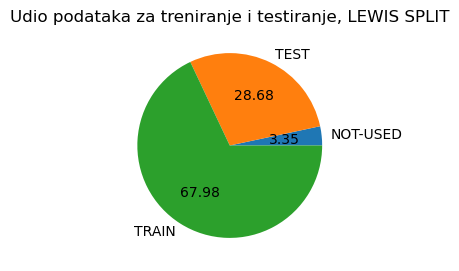

In [17]:
count_per_lewissplit = clanci.groupby('LEWISSPLIT').count().loc[:, 'NEWID'].values
labels = clanci.groupby('LEWISSPLIT').count().index.values
percent = (count_per_lewissplit/len(clanci))*100

# pokazuje postotak članaka koji su se koristi u kojim skupinama
plt.figure(figsize=(10, 3))
plt.pie(percent, labels=labels, autopct='%.2f')
plt.title("Udio podataka za treniranje i testiranje, LEWIS SPLIT")
plt.show()

#### Inkonzistentni podaci

In [18]:
# inkonzistentni podaci
dateline_helper_dataframe = podaci.copy()
dateline_helper_dataframe['DATELINE'] = dateline_helper_dataframe.DATELINE.str.upper()
dateline_helper_dataframe['DATELINE'] = dateline_helper_dataframe.DATELINE.str.replace('JANUARY', 'JAN')
dateline_helper_dataframe['DATELINE'] = dateline_helper_dataframe.DATELINE.str.upper().str.replace('FEBRUARY', 'FEB')
dateline_helper_dataframe['DATELINE'] = dateline_helper_dataframe.DATELINE.str.replace('MARCH', 'MAR').str.replace('NARCH', 'MAR')
dateline_helper_dataframe['DATELINE'] = dateline_helper_dataframe.DATELINE.str.replace('APRIL', 'APR')
dateline_helper_dataframe['DATELINE'] = dateline_helper_dataframe.DATELINE.str.replace('JUNE', 'JUN')
dateline_helper_dataframe['DATELINE'] = dateline_helper_dataframe.DATELINE.str.replace('JULY', 'JUL')
dateline_helper_dataframe['DATELINE'] = dateline_helper_dataframe.DATELINE.str.replace('AUGUST', 'AUG')
dateline_helper_dataframe['DATELINE'] = dateline_helper_dataframe.DATELINE.str.replace('SEPTEMBER', 'SEP')
dateline_helper_dataframe['DATELINE'] = dateline_helper_dataframe.DATELINE.str.replace('OCTOBER', 'OCT')
dateline_helper_dataframe['DATELINE'] = dateline_helper_dataframe.DATELINE.str.replace('NOVEMBER', 'NOV')
dateline_helper_dataframe['DATELINE'] = dateline_helper_dataframe.DATELINE.str.replace('DECEMBER', 'DEC')


dateline_helper_dataframe = dateline_helper_dataframe.loc[dateline_helper_dataframe.DATELINE.notnull(), :]
dateline_helper_dataframe = dateline_helper_dataframe.DATELINE.str.extract(r',[\s]*(\w+)[\s]*[\d]*[\s]*-')
dateline_helper_dataframe = dateline_helper_dataframe.loc[dateline_helper_dataframe[0].notnull(), :]

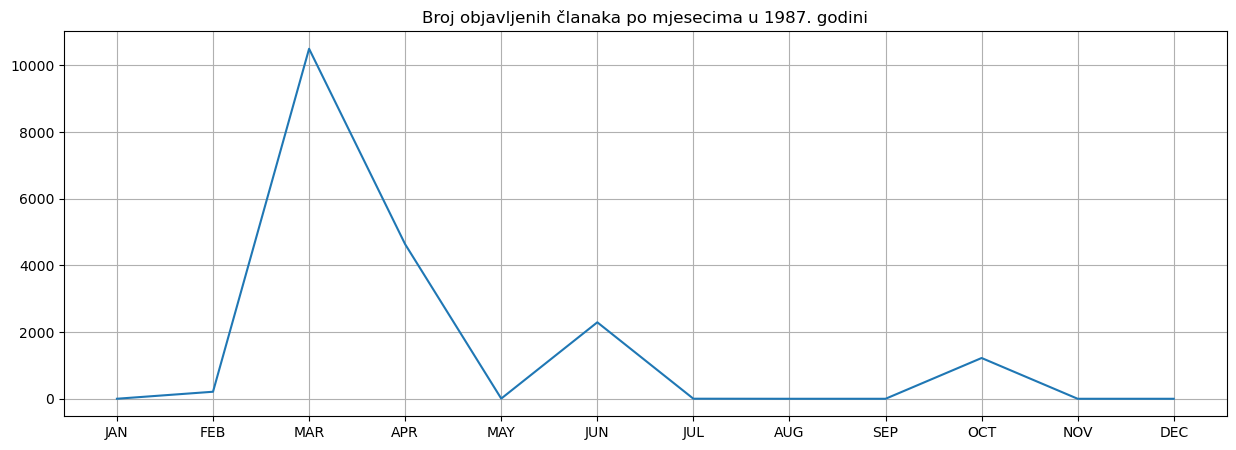

In [19]:
months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
count_months = {}
for month in months:
    count_months[month] = 0
    
nul = 0
for month in dateline_helper_dataframe.to_numpy():
    try:
        count_months[month[0]] += 1
    except:
        nul += 1

#print(count_months)
plt.figure(figsize=(15, 5))
plt.plot(count_months.keys(), count_months.values())
plt.grid()
plt.title("Broj objavljenih članaka po mjesecima u 1987. godini")
plt.show()

### Podaci o kategorijama

In [20]:
exchanges = []
orgs = []
people = []
places = []
topics = []


file_content = open(os.path.join("reuters21578", "all-exchanges-strings.lc.txt"), mode = 'r').read()
exchanges = file_content.split("\n")
file_content = open(os.path.join("reuters21578", "all-orgs-strings.lc.txt"), mode = 'r').read()
orgs = file_content.split("\n")
file_content = open(os.path.join("reuters21578", "all-people-strings.lc.txt"), mode = 'r').read()
people = file_content.split("\n")
file_content = open(os.path.join("reuters21578", "all-places-strings.lc.txt"), mode = 'r').read()
places = file_content.split("\n")
file_content = open(os.path.join("reuters21578", "all-topics-strings.lc.txt"), mode = 'r').read()
topics = file_content.split("\n")

#print("Sve moguće vrijednosti klase exchanges:\n", exchanges)
#print("Sve moguće vrijednosti klase orgs:\n", orgs)
#print("Sve moguće vrijednosti klase people:\n", people)
#print("Sve moguće vrijednosti klase places:\n", places)
#print("Sve moguće vrijednosti klase topics:\n", topics)


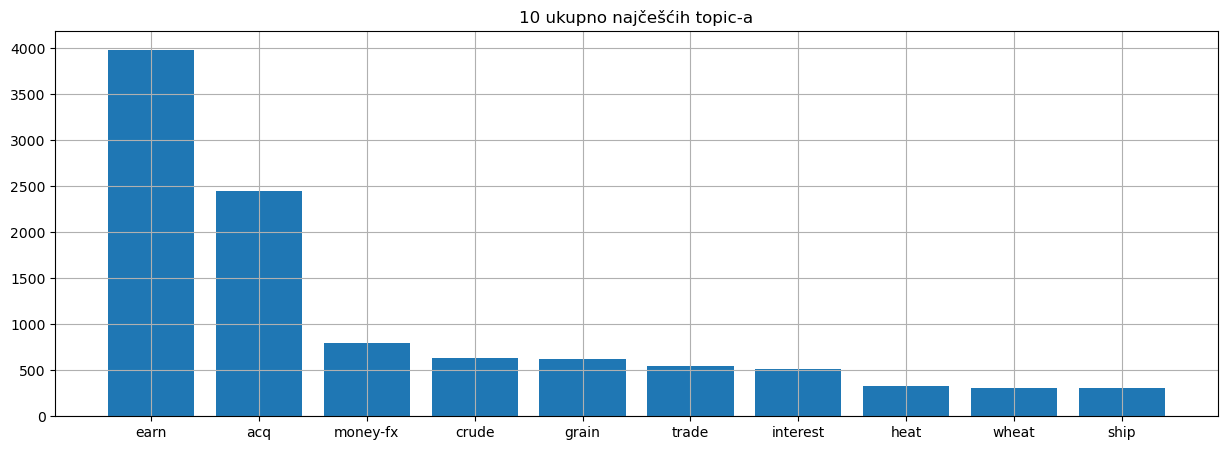

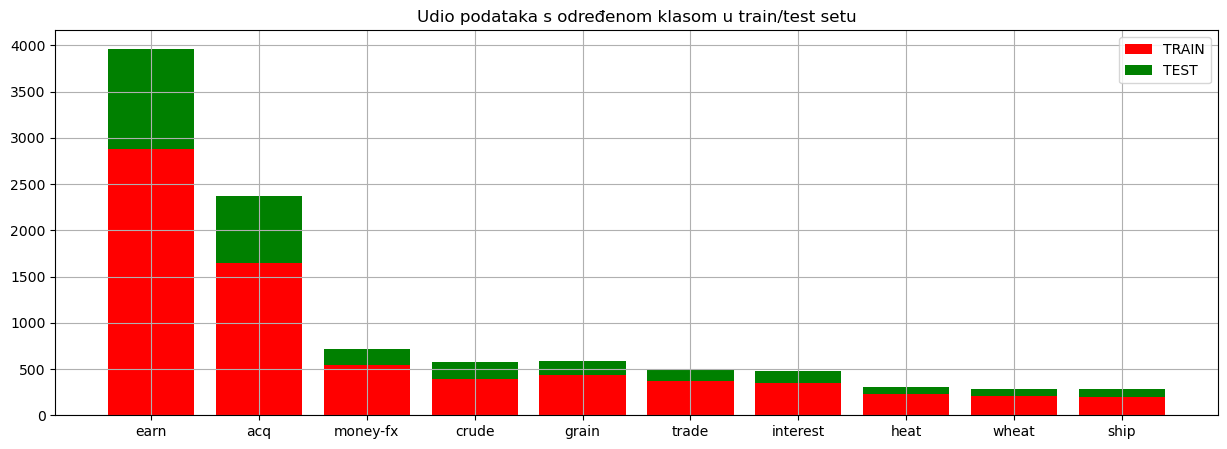

In [21]:
most_freq_topic = {}
for topic in topics:
    most_freq_topic[topic] = dataframe.TOPICS.str.contains(topic).sum()

del most_freq_topic['']
topic_map_top_10 = dict(sorted(most_freq_topic .items(), key=lambda x: -x[1])[0:10]) #sortiramo od najčešćeg topica prema manje čestima

plt.figure(figsize=(15, 5))
plt.bar(topic_map_top_10.keys(), topic_map_top_10.values())
plt.title("10 ukupno najčešćih topic-a")
plt.grid()
plt.show()

count_topic_train = {}
count_topic_test = {}
for topic in topic_map_top_10.keys():
    count_topic_train[topic] = dataframe[dataframe.LEWISSPLIT == "TRAIN"].TOPICS.str.contains(topic).sum()
    count_topic_test[topic] =  dataframe[dataframe.LEWISSPLIT == "TEST"].TOPICS.str.contains(topic).sum()

plt.figure(figsize=(15, 5))
plt.grid()
plt.bar(topic_map_top_10.keys(), count_topic_train.values(), color='red', label='TRAIN')
plt.bar(topic_map_top_10.keys(), count_topic_test.values(), color='green', label='TEST', bottom=list(count_topic_train.values())) # bottom -> postavi vrijednost NA count_per_title_died
plt.title("Udio podataka s određenom klasom u train/test setu")
plt.legend(loc='best')

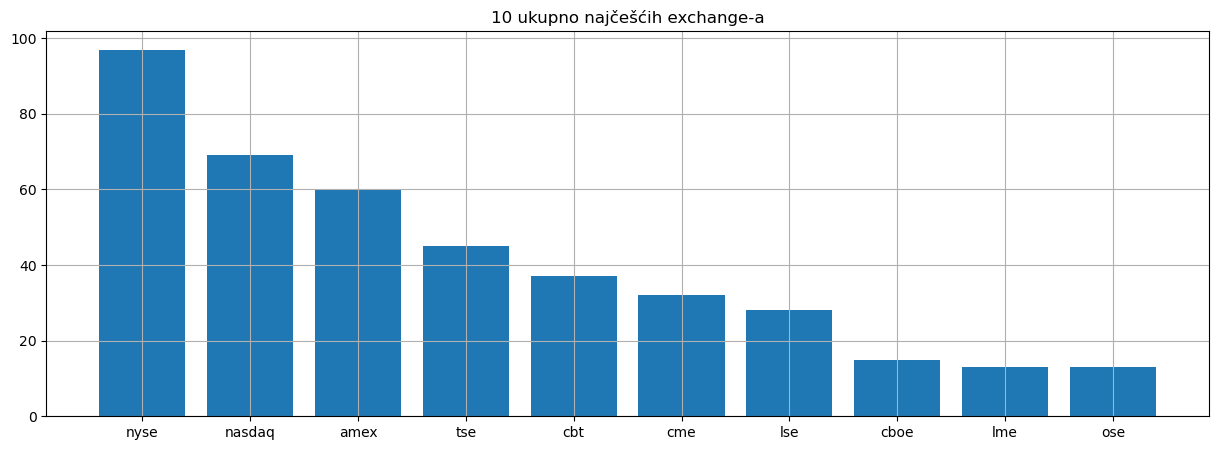

In [22]:
most_freq_exchanges = {}
for exchange in exchanges:
    most_freq_exchanges[exchange] = dataframe.EXCHANGES.str.contains(exchange).sum()

del most_freq_exchanges['']
exchanges_map_top_10 = dict(sorted(most_freq_exchanges.items(), key=lambda x: -x[1])[0:10]) #sortiramo od najčešćeg topica prema manje čestima

plt.figure(figsize=(15, 5))
plt.bar(exchanges_map_top_10.keys(), exchanges_map_top_10.values())
plt.title("10 ukupno najčešćih exchange-a")
plt.grid()
plt.show()

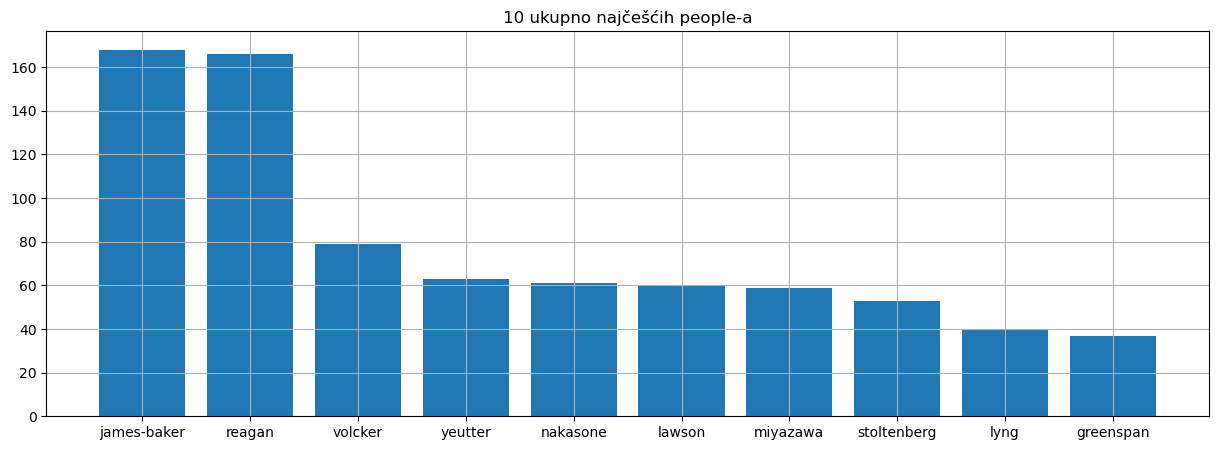

In [23]:
most_freq_people = {}
for p in people:
    most_freq_people[p] = dataframe.PEOPLE.str.contains(p).sum()

del most_freq_people['']
people_map_top_10 = dict(sorted(most_freq_people.items(), key=lambda x: -x[1])[0:10]) #sortiramo od najčešćeg topica prema manje čestima

plt.figure(figsize=(15, 5))
plt.bar(people_map_top_10.keys(), people_map_top_10.values())
plt.title("10 ukupno najčešćih people-a")
plt.grid()
plt.show()

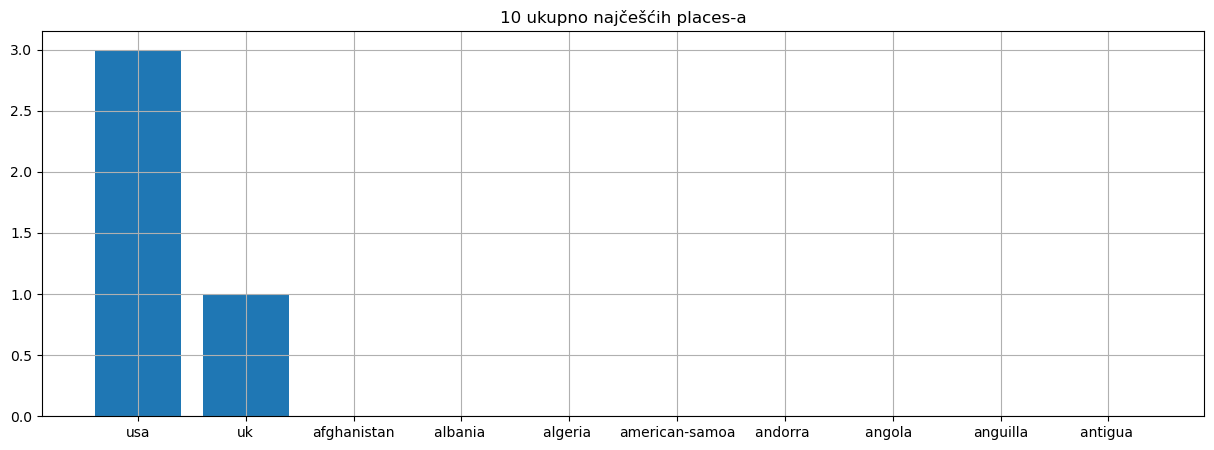

In [24]:
most_freq_places = {}
for p in places:
    most_freq_places[p] = dataframe.PEOPLE.str.contains(p).sum()

del most_freq_places['']
places_map_top_10 = dict(sorted(most_freq_places.items(), key=lambda x: -x[1])[0:10]) #sortiramo od najčešćeg topica prema manje čestima

plt.figure(figsize=(15, 5))
plt.bar(places_map_top_10.keys(), places_map_top_10.values())
plt.title("10 ukupno najčešćih places-a")
plt.grid()
plt.show()

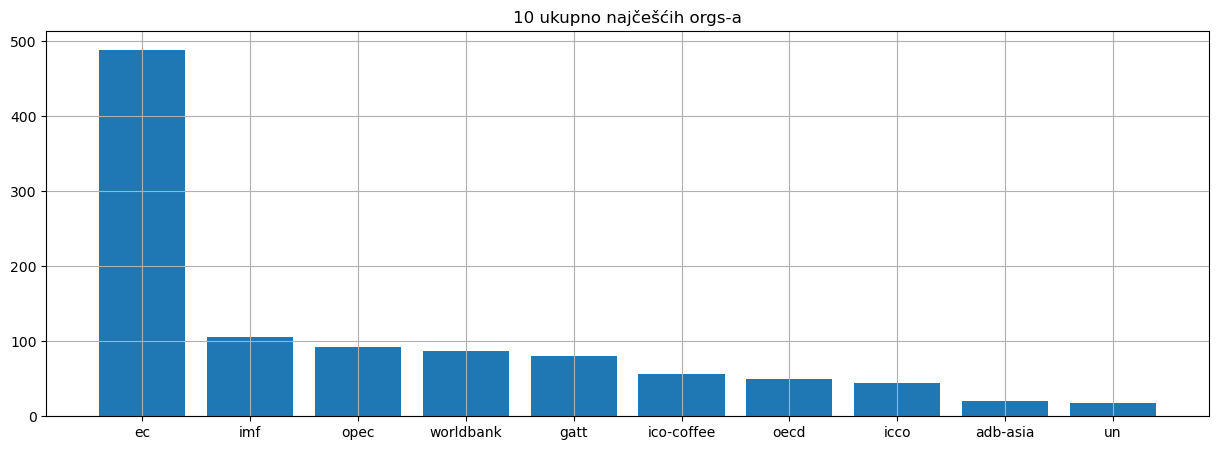

In [25]:
most_freq_orgs = {}
for o in orgs:
    most_freq_orgs[o] = dataframe.ORGS.str.contains(o).sum()

del most_freq_orgs['']
orgs_map_top_10 = dict(sorted(most_freq_orgs.items(), key=lambda x: -x[1])[0:10]) #sortiramo od najčešćeg topica prema manje čestima

plt.figure(figsize=(15, 5))
plt.bar(orgs_map_top_10.keys(), orgs_map_top_10.values())
plt.title("10 ukupno najčešćih orgs-a")
plt.grid()
plt.show()

#### Dodavanje stupca

In [26]:
podaci_added = podaci.copy()
podaci_added['WORD_COUNT'] = podaci_added.apply(lambda row: len(row.BODY), axis=1)
podaci_added.head()

,TOPICS,PLACES,PEOPLE,ORGS,EXCHANGES,TITLE,DATELINE,TOPICS_ENUM,FILENAME,DATE,BODY,TEXT TYPE,LEWISSPLIT,CGISPLIT,WORD_COUNT
0,['cocoa'],"['el-salvador', 'usa', 'uruguay']",<NA>,<NA>,<NA>,BAHIA COCOA REVIEW,"SALVADOR, Feb 26 -",2,reut2-000.sgm,26-FEB-1987 15:01:01.79,Showers continued throughout the week in the B...,0,2,1,2864
1,<NA>,['usa'],<NA>,<NA>,<NA>,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,"CLEVELAND, Feb 26 -",1,reut2-000.sgm,26-FEB-1987 15:02:20.00,Standard Oil Co and BP North America Inc said ...,0,2,1,445
2,<NA>,['usa'],<NA>,<NA>,<NA>,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,"HOUSTON, Feb 26 -",1,reut2-000.sgm,26-FEB-1987 15:03:27.51,Texas Commerce Bancshares Inc's Texas Commerce...,0,2,1,334
3,<NA>,"['usa', 'brazil']",<NA>,<NA>,<NA>,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,"LOS ANGELES, Feb 26 -",1,reut2-000.sgm,26-FEB-1987 15:07:13.72,BankAmerica Corp is not under pressure to act ...,0,2,1,2853
4,"['grain', 'wheat', 'corn', 'barley', 'oat', 's...",['usa'],<NA>,<NA>,<NA>,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,"WASHINGTON, Feb 26 -",2,reut2-000.sgm,26-FEB-1987 15:10:44.60,The U.S. Agriculture Department reported the f...,0,2,1,1145


### Histogram

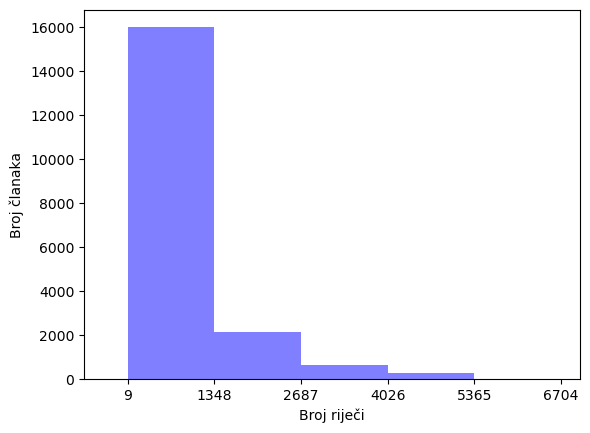

In [27]:
interval = (podaci_added.WORD_COUNT.max() - podaci_added.WORD_COUNT.min())/10
bins = [podaci_added.WORD_COUNT.min()]
xticks = [podaci_added.WORD_COUNT.min()]
names = []
for i in range(1, 10):
    bins.append(int(podaci_added.WORD_COUNT.min()+interval*i))
    xticks.append(int(podaci_added.WORD_COUNT.min()+interval*i))
    names.append(" " + str(int(podaci_added.WORD_COUNT.min() + (i-1)*interval)) + " - " + str(int(podaci_added.WORD_COUNT.min() + i*interval)))

podaci_added['WORD_COUNT_RANGE'] = pd.cut(podaci_added['WORD_COUNT'], bins, labels=names)

plt.hist(podaci_added.WORD_COUNT, color='blue', alpha=0.5)
plt.xlabel("Broj riječi")
plt.ylabel("Broj članaka")
plt.xticks(xticks)
plt.xlim(xmax = 7000)
plt.show()

### Kutijasti graf

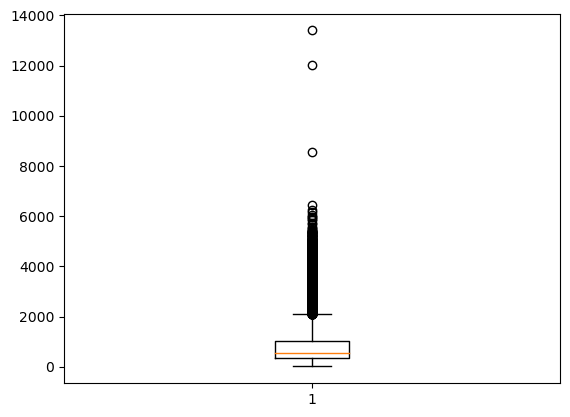

In [28]:
plt.boxplot(podaci_added.WORD_COUNT) # kružići su outliersi, whiskers su min i max vrijednosti, a narančasta crta je srednja vrijednost
plt.show()

### Podaci o riječima u tijelima članaka

In [ ]:
#!pip install nltk
import nltk as nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
dataframe = podaci.loc[podaci.BODY.notnull(), :]

dataframe['BODY'] = dataframe['BODY'].replace('[\n\t0-9]',' ', regex=True) # uklanjamo sve prijelaze u novi red, tabulatore i brojeve iz tijela članaka

dataframe['BODY'] = dataframe['BODY'].replace('[\.\-"\#$%&!/,;]',' ', regex=True) #

dataframe['BODY'] = dataframe['BODY'].str.lower()

dataframe['BODY'] = dataframe['BODY'].replace('[\s]', ' ', regex=True)

dataframe['BODY'] = dataframe['BODY'].replace('[^a-zA-Z0-9\n \.]', '', regex=True)

dataframe['BODY'] = dataframe['BODY'].replace('[^\x00-\x7f]', '', regex=True)

dataframe['BODY'] = dataframe['BODY'].encode()

#print(dataframe['BODY'])

from collections import Counter
count = Counter()

exclude=stopwords.words('english')
#print(exclude)

dataframe.to_csv("clanci_stripped.csv")

words_per_row = dataframe['BODY'].str.split(" ")
words_per_row.to_numpy()
for words in words_per_row.to_numpy():
    lista = [s for s in words if s != '']
    for word in lista:
        if word not in exclude:
            if len(word) > 3:
                count[word] += 1

plt.figure(figsize=(15, 5))
plt.title("10 najčešćih riječi")
for item in count.most_common(10):
    plt.bar(item[0], item[1])
plt.show()